# Problem B1: First autocorrelation inequality
For any function $f:\mathbb{R} \rightarrow \mathbb{R}$, define the *autoconvolution* of $f$, written $f*f$, as
$$f*f (t) := \int_\mathbb{R} f(t-x) f(x)\ dx.$$

Let $C_1$ denote the largest constant for which one has
\begin{equation}
 \max_{-1/2 \leq t \leq 1/2} f*f(t) \geq C_1 \left(\int_{-1/4}^{1/4} f(x)\ dx\right)^2
\end{equation}
for all non-negative $f: \mathbb{R} \rightarrow \mathbb{R}$.  This problem arises in additive combinatorics, relating to the size of Sidon sets.  It is currently known that
$$ 1.28 \leq C_1 \leq 1.5098$$
with the lower bound proven by [Cloninger and Steinerberger (2017)](https://www.ams.org/journals/proc/2017-145-08/S0002-9939-2017-13690-9/S0002-9939-2017-13690-9.pdf) and the upper bound achieved by [Matolcsi and Vinuesa (2010)](https://www.sciencedirect.com/science/article/pii/S0022247X10006001) via a step function construction. AlphaEvolve found a step function with 600 equally-spaced intervals on $[-1/4,1/4]$ that gives a better upper bound of $C_1 \leq 1.5053$.

## Compute the step function, the integral, and the autoconvolution

For step func. 
$$f(x) = \sum_{i=0}^{P-1} h_i \mathbf{1}_{[x_i, x_{i+1})}(x)$$  
where
$$ x_i = -\frac{1}{4} + \frac{i}{2P}, \text{ and heights } h_i \ge 0:$$
$$
\begin{aligned}
% Integral
\text{Integral:}\quad \int_{-1/4}^{1/4} f(x) \,dx &= \frac{1}{2P} \sum_{i=0}^{P-1} h_i
\\[2ex]
% Autoconvolution
\text{Autoconv. knots:}\quad (f*f)(t_m) &= 
\begin{cases} 
0 & \text{if } m=0 \text{ or } m=2P \\
\frac{1}{2P} \sum_{k=\max(0, m-P)}^{\min(P-1, m-1)} h_k h_{m-1-k} & \text{if } 1 \le m \le 2P-1
\end{cases}
\\[0.5ex]
&\quad \text{where } t_m = -\frac{1}{2} + \frac{m}{2P} \quad (m=0, \dots, 2P).
\end{aligned}
$$

## The structure of the optimization problem

Let $f_h$ denote the step function with heights $h$. We're trying to optimize the function:
\begin{align*}
\mathrm{minimize} &\; L(h) := \max_{-1/2\leq t \leq 1/2} (f_h\ast f_h)(t) \\
\text{subject to } &\; \int_{-1/4}^{1/4} f_h(t) dt = \frac{\mathbf{1}^T h}{2P} = 1 \\
&\; h \geq 0.
\end{align*}
This is a nonsmooth qudaratic optimization problem over a simplex.

Note that this is not convex: set $P=2$ and $h_0+h_1=2P=4$. The objective is
$$
\frac{1}{2P}\max(h_0^2, 2h_0h_1, h_1^2)
$$
We can parameterize the feasible region by $h_0 \in [0,4]$. Then there is a region where $2h_0h_1 = 2h_0(4-h_0)$ attains the max and the function becomes concave.


## Plot the step function and the autoconvolution

In [ ]:
# script assumes 'compute_integral_of_step_function' and 'compute_autoconvolution_values'
# (from your previous code block) are already defined and executable in the notebook.
from utils import *

# --- main script logic ---
P_val = 600  # number of pieces for the step function
f_interval = (-0.25, 0.25) # interval for f(x)

f_x_min, f_x_max = f_interval
f_delta_x = (f_x_max - f_x_min) / P_val

# 1. sample random heights (non-negative)
# using float64 for precision, requires_grad=False for plotting/evaluation only
height_values = torch.rand(P_val, dtype=torch.float64) 
# for more structured/sparse functions, you could try:
# height_values = torch.abs(torch.randn(P_val, dtype=torch.float64)) * (torch.rand(P_val, dtype=torch.float64) > 0.7).double()


# 2. compute integral of f(x)
integral_value = compute_integral_of_step_function(height_values, f_delta_x)

# 3. compute autoconvolution (f*f)(t) knot values
# (2*P_val + 1) values for t_m from 2*f_x_min to 2*f_x_max
autoconv_knot_vals = compute_autoconvolution_values(height_values, f_delta_x, P_val)
max_autoconv_value = torch.max(autoconv_knot_vals)

# 4. calculate the ratio for C1 estimate
# (max f*f(t)) / (integral f(x) dx)^2
if integral_value.item() == 0:
    c1_ratio = float('inf') if max_autoconv_value.item() > 0 else 0.0 # handle division by zero
else:
    c1_ratio = max_autoconv_value / (integral_value**2)

print(f"--- Function Details (P={P_val}) ---")
# print(f"Heights (h_i, first 10): {height_values.numpy()[:10]}") # uncomment if you want to see heights
print(f"Integral of f(x): {integral_value.item():.6f}")
print(f"Max value of autoconvolution (f*f)(t): {max_autoconv_value.item():.6f}")
print(f"Ratio max(f*f) / (integral(f))^2: {c1_ratio.item():.6f}")


# 5. plotting
# plot f(x)
plot_rendered_step_function(height_values.numpy(), f_interval, title=f"Random Step Function f(x) (P={P_val})")

# plot f*f(t)
# autoconvolution is defined on [2*f_x_min, 2*f_x_max]
conv_t_knots = np.linspace(2 * f_x_min, 2 * f_x_max, 2 * P_val + 1, dtype=float)
plot_rendered_convolution(conv_t_knots, autoconv_knot_vals.numpy(), title=f"Autoconvolution f*f(t) (P={P_val})")



## Plotting Google's solution

In [ ]:
# Also plot google's solution
h_params_google = return_height_params_google_simplex()
autoconv_knot_vals_google = compute_autoconvolution_values(h_params_google, f_delta_x, P_val)
max_autoconv_value_google = torch.max(autoconv_knot_vals_google)

plot_rendered_step_function(h_params_google.detach().numpy(), f_interval, title=f"Google's Step Function f(x) (P={P_val})")
plot_rendered_convolution(conv_t_knots, autoconv_knot_vals_google.detach().numpy(), title=f"Google'sAutoconvolution f*f(t) (P={P_val})")

## Algorithm 1: (Projected) Polyak subgradient method

The algorithm 
$$
h_+ = \mathrm{proj}_{\Delta_{2P}}\left(h - \frac{L(h) - L^*}{\| \nabla L(h) \|^2} \nabla L(h)\right)
$$
where $L^*$ is the target loss.

There is a subtlety here: we don't know what the optimal value is.

### Polyak with Random initialization

In [ ]:
P_val = 600
from utils import *
# Initialize random height parameters
h_params_polyak = torch.rand(P_val, dtype=torch.float64)
h_params_polyak.requires_grad = True
# Define the projection and loss
def projection(x): 
    return projection_simplex_pytorch(x, 2*P_val)
h_params_polyak.data = projection(h_params_polyak.data)
loss_fn = constrained_loss(P_val)

# Setting up history
if 'history_polyak_constrained_random' not in locals():
    history_polyak_constrained_random = {}
else:
    h_params_polyak.data = history_polyak_constrained_random['best_h_params'].data.clone()

# Setting up parameters for Polyak
max_iter = 1000
target_loss = 1.505
print_every = 1000

history_polyak_constrained_random = polyak_subgradient_method(h_params_polyak,loss_fn, max_iter, target_loss, print_every, history_polyak_constrained_random, projection)
print("Best loss found:", history_polyak_constrained_random['min_loss_found'])
# semilogy plot of loss history
plt.semilogy(history_polyak_constrained_random['loss_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Polyak subgradient method: Loss History")
plt.show()


In [ ]:
autoconv_knot_vals_polyak = compute_autoconvolution_values(history_polyak_constrained_random['best_h_params'], f_delta_x, P_val)
max_autoconv_value_polyak = torch.max(autoconv_knot_vals_polyak)

plot_rendered_step_function(history_polyak_constrained_random['best_h_params'].detach().numpy(), f_interval, title=f"Step Function f(x) (After Polyak) (P={P_val})")
plot_rendered_convolution(conv_t_knots, autoconv_knot_vals_polyak.detach().numpy(), title=f"Autoconvolution f*f(t) (After Polyak) (P={P_val})")

torch.set_printoptions(precision=16, sci_mode=False)  # global setting
# need 16 digits of precision for the loss for the print statement to be correct

### Polyak started at the Google solution 

In [ ]:
P_val = 600
from utils import *
h_params_polyak_google = h_params_google.data.detach().clone() # initialize variable at google's solution.
h_params_polyak_google.requires_grad = True
# Define the projection and loss
def projection(x): 
    return projection_simplex_pytorch(x, 2*P_val)
h_params_polyak_google.data = projection(h_params_polyak_google.data)
loss_fn = constrained_loss(P_val)

# Setting up history
if 'history_polyak_constrained_google' not in locals():
    history_polyak_constrained_google = {}
else:
    h_params_polyak_google.data = history_polyak_constrained_google['best_h_params'].data.clone()

max_iter = 1000
target_loss_google = 1.505292
print_every = 1000

history_polyak_constrained_google = polyak_subgradient_method(h_params_polyak_google, loss_fn, max_iter, target_loss_google, print_every, history_polyak_constrained_google, projection)

print("Best loss found (Google solution initialization):", history_polyak_constrained_google['min_loss_found'])

# semilogy plot of loss history
plt.semilogy(history_polyak_constrained_google['loss_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Polyak subgradient method (Google solution initialization): Loss History")
plt.show()


In [ ]:
# Also plot google's solution
autoconv_knot_vals_google_polyak = compute_autoconvolution_values(history_polyak_constrained_google['best_h_params'], f_delta_x, P_val)
max_autoconv_value_google_polyak = torch.max(autoconv_knot_vals_google_polyak)

plot_rendered_step_function(history_polyak_constrained_google['best_h_params'].detach().numpy(), f_interval, title=f"Google's Step Function f(x) (After Polyak) (P={P_val})")
plot_rendered_convolution(conv_t_knots, autoconv_knot_vals_google_polyak.detach().numpy(), title=f"Google's Autoconvolution f*f(t) (After Polyak) (P={P_val})")

torch.set_printoptions(precision=16, sci_mode=False)  # global setting

print("best_height_params_polyak_google", history_polyak_constrained_google['best_h_params'])
# need 16 digits of precision for the loss for the print statement to be correct

## Changing the loss function to remove constraints

We're going to precompose the loss function with a softmax. This implicitly constrains the functions to the simplex. I.e., we will optimize

$$
L(2P\mathrm{softmax}(w))
$$


## Polyak on unconstrained (softmax) loss

In [ ]:
from utils import *
P_val = 600
h_params_polyak_unconstrained = torch.rand(P_val, dtype=torch.float64)
h_params_polyak_unconstrained.requires_grad = True

loss_f_softmax = unconstrained_loss(P_val)

if 'history_polyak_unconstrained_random' not in locals():
    history_polyak_unconstrained_random = {}
else:
    h_params_polyak.data = history_polyak_unconstrained_random['best_h_params'].data.clone()

max_iter = 100
target_loss = 1.52
print_every = 1000

history_polyak_unconstrained_random = polyak_subgradient_method(h_params_polyak_unconstrained, loss_f_softmax, max_iter, target_loss, print_every, history_polyak_unconstrained_random)

print("Best loss found:", history_polyak_unconstrained_random['min_loss_found'])

# semilogy plot of loss history
plt.semilogy(history_polyak_unconstrained_random['loss_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Polyak subgradient method: Loss History")
plt.show()

plt.semilogy(history_polyak_unconstrained_random['grad_norm_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Polyak subgradient method: Loss History")
plt.show()


## BFGS on unconstrained loss (with weak wolfe line search)
    


In [1]:
P_val = 600
from utils import *
# h_params_bfgs_unconstrained = (torch.randn(P_val).abs() * 0.01 + 0.01).log()
h_params_bfgs_unconstrained = torch.randn(P_val)
# h_params_bfgs_unconstrained = h_params_google # Start from google's solution if you want.
# h_params_bfgs_unconstrained.data = torch.log(h_params_bfgs_unconstrained.data)
h_params_bfgs_unconstrained.requires_grad = True



if 'history_bfgs_unconstrained_random' not in locals():
    history_bfgs_unconstrained_random = {}
else:
    h_params_bfgs_unconstrained.data = history_bfgs_unconstrained_random['best_h_params'].data.clone()

max_iter = 20
bfgs_params = {}
bfgs_params['lr'] = 1
bfgs_params['history_size'] = 2000
bfgs_params['ls_params'] = {'c1': 0.0001, 'c2': 0.9}
# bfgs_params['line_search_fn'] = None # no line search function. Will likely blow up.
bfgs_params['line_search_fn'] = 'weak_wolfe' # good for later iterations
print_every = 100

loss_f_softmax = unconstrained_loss(P_val)
history_bfgs_unconstrained_random = bfgs_method(h_params_bfgs_unconstrained, loss_f_softmax, max_iter, bfgs_params, print_every, history_bfgs_unconstrained_random)
# loss_f_normalized = scale_invariant_h_squared_loss(P_val=600)
# history_bfgs_unconstrained_random = bfgs_method(h_params_bfgs_unconstrained, loss_f_normalized, max_iter, bfgs_params, print_every, history_bfgs_unconstrained_random)
# loss_f_normalized_allow_negative = scale_invariant_h_squared_loss(P_val=600)
# history_bfgs_unconstrained_random = bfgs_method(h_params_bfgs_unconstrained, loss_f_normalized_allow_negative, max_iter, bfgs_params, print_every, history_bfgs_unconstrained_random)


print("Best loss found:", history_bfgs_unconstrained_random['min_loss_found'])


# semilogy plot of loss history
plt.semilogy(history_bfgs_unconstrained_random['loss_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("BFGS method: Loss History")
plt.show()

plt.semilogy(history_bfgs_unconstrained_random['grad_norm_history'])
plt.xlabel("Iteration")
plt.ylabel("Grad norm history")
plt.title("BFGS method: Gradient Norm History")
plt.show()

NameError: name 'torch' is not defined

## NTD on unconstrained loss 

From https://github.com/COR-OPT/ntd.py

In [ ]:
P_val = 600
from utils import *
h_params_ntd_unconstrained = torch.rand(P_val, dtype=torch.float64)
# h_params_ntd_unconstrained = h_params_google # Start from google's solution if you want.
h_params_ntd_unconstrained.data = torch.log(h_params_ntd_unconstrained.data)
h_params_ntd_unconstrained.requires_grad = True

loss_f_softmax = unconstrained_loss(P_val)
loss_f_normalized = scale_invariant_h_squared_loss(P_val=600)

if 'history_ntd_unconstrained_random' not in locals():
    history_ntd_unconstrained_random = {}
else:
    h_params_ntd_unconstrained.data = history_ntd_unconstrained_random['best_h_params'].data.clone()

max_iter = 1
ntd_params = {}
ntd_params['adaptive_grid_size'] = True
ntd_params['verbose'] = False
ntd_params['max_grid_size'] = 20 # 50 
# ntd_params['opt_f'] = 1.5052
ntd_params['min_goldstein_iters'] = 1
ntd_params['use_trust_region'] = True
print_every = 1

# loss_f_softmax = unconstrained_loss(P_val) # softmax loss
# history_ntd_unconstrained_random = ntd_method(h_params_ntd_unconstrained, loss_f_softmax max_iter, ntd_params, print_every, history_ntd_unconstrained_random)
loss_f_normalized = scale_invariant_h_squared_loss(P_val=600) # alternative loss 
history_ntd_unconstrained_random = ntd_method(h_params_ntd_unconstrained, loss_f_normalized, max_iter, ntd_params, print_every, history_ntd_unconstrained_random)
# loss_f_normalized_allow_negative = scale_invariant_h_squared_loss(P_val=600)
# history_ntd_unconstrained_random = ntd_method(h_params_ntd_unconstrained, loss_f_normalized_allow_negative, max_iter, ntd_params, print_every, history_ntd_unconstrained_random)

print("Best loss found:", history_ntd_unconstrained_random['min_loss_found'])

# semilogy plot of loss history
plt.semilogy(history_ntd_unconstrained_random['loss_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("NTD method: Loss History")
plt.show()

plt.semilogy(history_ntd_unconstrained_random['grad_norm_history'])
plt.xlabel("Iteration")
plt.ylabel("Grad norm history")
plt.title("NTD method: Gradient Norm History")
plt.show()

# Prox linear method 

Basic idea: The objective function is a max of smooth function.

$$
L(h) = \max_{i} \ell_i(h)
$$

So we linearize them smooth function and then minimize the linearization over the constraint. In particular, given current iterate $h$, we solve:

$$
\begin{aligned}
h_+ = &\mathrm{argmin}_{h'} \max_{i} \{ \ell_i(h) + \nabla \ell_i(h) (h' - h) \} + \frac{\gamma}{2} \|h' - h\|^2\\
&\text{subject to }  h' \in \Delta_{2P}
\end{aligned}
$$

Note: 
- For large enough $\gamma$ (bigger than maximal lipschitz constant of gradient of $\ell_i$), each step is guaranteed to reduce the loss (if not at critical point), but progress is slower.
- For $\gamma = 0$, it takes bigs steps, good for initial iterates, but can start to cycle. 
- Lowest sol'n so far found is 1.5160005027, and i'm still running the method. It uses 1000 heights instead of 600.



In [ ]:
import os
from utils import *
P_val = 600
h_params_prox_linear = torch.rand(P_val, dtype=torch.float64)
# h_params_prox_linear = initialize_from_matolcsi_vinuesa_best_step_208(2*P_val) #Need n = 208, but get's lowest loss.

# h_params_prox_linear = h_params_google.detach().clone() # Start from google's solution if you want.
h_params_prox_linear.data = 2*P_val*h_params_prox_linear.data/sum(h_params_prox_linear.data)
h_params_prox_linear.requires_grad = True
loss_fn = constrained_loss(P_val)

file_path = 'best_found_so_far_prox_linear_P_val_' + str(P_val) + '.pt'
if os.path.exists(file_path):
    saved_best_h_params = torch.load(file_path)
    if 'history_prox_linear' not in locals():
        history_prox_linear = {}
        history_prox_linear['best_h_params'] = saved_best_h_params
        h_params_prox_linear.data = saved_best_h_params.data.clone()
    else:
        if loss_fn(saved_best_h_params) > (loss_fn(history_prox_linear['best_h_params'])):
            torch.save(history_prox_linear['best_h_params'], file_path)
            h_params_prox_linear.data = history_prox_linear['best_h_params'].data.clone()
            print("Current point better than point in file. Saving current point.")
        else:
            h_params_prox_linear.data = saved_best_h_params.data.clone()
            print("Point in file better than current point. Loading point in file.")
else:
    if 'history_prox_linear' not in locals():
        history_prox_linear = {}
    else: 
        torch.save(history_prox_linear['best_h_params'], file_path)
        h_params_prox_linear.data = history_prox_linear['best_h_params'].data.clone()
        print("No point in file. Saving current point.")

max_iter = 1 # try to run around 10-30 iterations at a time. can always pause and resume.
delta_x = 0.5 / P_val
# gamma_prox = delta_x makes sense since this is the weak convex parameter of the function.
gamma_prox = delta_x # initially set to zero, but then try .00001, .0001, .001, etc. set as low as possible while you still make progress.
print_every = 1
# Solver parameters. Seems like CLARABEL is better for this problem.
## For ECOS, Set error tolerances around 1e-9, then gradually decrease.
# prox_linear_params = {'solver' : 'ECOS', 'gamma_prox': gamma_prox, 'abstol': 1e-10, 'reltol': 1e-09, 'feastol': 1e-09, 'max_iters': 2000, 'verbose': False}
## Clarabel can handle much lower tolerances.
tol = 1e-17
prox_linear_params = {'solver' : 'CLARABEL', 'gamma_prox': gamma_prox, 'abstol': tol, 'reltol': tol, 'feastol': tol, 'max_iters': 2000, 'verbose': False}
history_prox_linear = prox_linear_method(h_params_prox_linear, loss_fn, print_every, max_iter, prox_linear_params, history_prox_linear)

print("Best loss found:", history_prox_linear['min_loss_found'])

# semilogy plot of loss history
plt.semilogy(history_prox_linear['loss_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Proximal linear method: Loss History")
plt.show()

plt.semilogy(history_prox_linear['grad_norm_history'])
plt.xlabel("Iteration")
plt.ylabel("Grad norm history")
plt.title("Proximal linear method: Gradient Norm History")
plt.show()

torch.save(history_prox_linear['best_h_params'], file_path)
h_params_prox_linear.data = history_prox_linear['best_h_params'].data.clone()
print("No point in file. Saving current point.")

### Plot autococonvolution of the best found so far

In [ ]:

saved_best_h_params = history_prox_linear['best_h_params']
P_val = saved_best_h_params.shape[0]
file_path = 'best_found_so_far_prox_linear_P_val_' + str(P_val) + '.pt'
saved_best_h_params = torch.load(file_path)
f_interval = (-0.25, 0.25) # interval for f(x)

f_x_min, f_x_max = f_interval
f_delta_x = (f_x_max - f_x_min) / P_val 
conv_t_knots = np.linspace(2 * f_x_min, 2 * f_x_max, 2 * P_val + 1, dtype=float)

autoconv_knot_vals_prox_linear = compute_autoconvolution_values(saved_best_h_params, f_delta_x, P_val)
max_autoconv_value_prox_linear = torch.max(autoconv_knot_vals_prox_linear)

plot_rendered_step_function(saved_best_h_params.detach().numpy(), f_interval, title=f"Prox-linear Step Function f(x) (P={P_val})")
plot_rendered_convolution(conv_t_knots, autoconv_knot_vals_prox_linear.detach().numpy(), title=f"Prox-linear Autoconvolution f*f(t) (P={P_val})")
print(sum(saved_best_h_params))

## LP approach described in [Matolcsi and Vinuesa (2010)](https://www.sciencedirect.com/science/article/pii/S0022247X10006001)

Current best from random initialization: 1.5122793377 using 600 pieces. 

Note: the original paper used some closer to 208 pieces. You can start the method from this solution below.

In [ ]:
import os
from utils import *
P_val = 208
# h_params_lp = torch.rand(P_val, dtype=torch.float64)
# h_params_lp = initialize_from_matolcsi_vinuesa_negative_step_40(2*P_val)
# h_params_lp = initialize_from_matolcsi_vinuesa_analytic(P_val) # Can't improve much on this for n = 208
h_params_lp = initialize_from_matolcsi_vinuesa_best_step_208(2*P_val) #Need n = 208, but get's lowest loss.
# make first half ones and second half random
# h_params_lp= h_params_google.detach().clone() # Start from google's solution if you want.
h_params_lp.data = 2*P_val*h_params_lp.data/sum(h_params_lp.data)
h_params_lp.requires_grad = True
loss_fn = constrained_loss(P_val=P_val)

file_path = 'best_found_so_far_lp_P_val_' + str(P_val) + '.pt'
if os.path.exists(file_path):
    saved_best_h_params_lp = torch.load(file_path)
    if 'history_lp' not in locals():
        history_lp = {}
        history_lp['best_h_params'] = saved_best_h_params_lp
        h_params_lp.data = saved_best_h_params_lp.data.clone()
    else:
        print(history_lp['best_h_params'].shape[0])
        if loss_fn(saved_best_h_params_lp) > (loss_fn(history_lp['best_h_params'])):
            torch.save(history_lp['best_h_params'], file_path)
            h_params_lp.data = history_lp['best_h_params'].data.clone()
            print("Current point better than point in file. Saving current point.")
        else:
            h_params_lp.data = saved_best_h_params_lp.data.clone()
            print("Point in file better than current point. Loading point in file.")
else:
    if 'history_lp' not in locals():
        history_lp = {}
    else: 
        torch.save(history_lp['best_h_params'], file_path)
        print("size of h_params_lp: ", h_params_lp.shape[0])
        print("No point in file. Saving current point.")

max_iter = 100 # try to run around 10-30 iterations at a time. can always pause and resume.
print_every = 1
line_search_iters = 40
# Solver parameters. Seems like CLARABEL is better for this problem.
## For ECOS, Set error tolerances around 1e-9, then gradually decrease.
# lp_params = {'solver' : 'ECOS', 'abstol': 1e-10, 'reltol': 1e-09, 'feastol': 1e-09, 'max_iters': 2000, 'verbose': False}
## Clarabel can handle much lower tolerances.
tol = 1e-17
lp_params = {'solver' : 'CLARABEL', 'abstol': tol, 'reltol': tol, 'feastol': tol, 'max_iters': 2000, 'verbose': False, 'line_search_iters' : line_search_iters}
history_lp = lp_method(h_params_lp, loss_fn, print_every, max_iter, lp_params, history_lp)

print("Best loss found:", history_lp['min_loss_found'])

# semilogy plot of loss history
plt.semilogy(history_lp['loss_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("LP method: Loss History")
plt.show()

plt.semilogy(history_lp['grad_norm_history'])
plt.xlabel("Iteration")
plt.ylabel("Grad norm history")
plt.title("LP method: Gradient Norm History")
plt.show()

# file_path = 'best_found_so_far_prox_linear_P_val_' + str(P_val) + '.pt'
torch.save(history_lp['best_h_params'], file_path)
h_params_lp.data = history_lp['best_h_params'].data.clone()
print("No point in file. Saving current point.")

In [ ]:
saved_best_h_params = history_lp['best_h_params']
saved_best_h_params = saved_best_h_params.detach().clone()/sum(saved_best_h_params)
P_val = saved_best_h_params.shape[0]
file_path = 'best_found_so_far_lp_P_val_' + str(P_val) + '.pt'
saved_best_h_params = torch.load(file_path)
f_interval = (-0.25, 0.25) # interval for f(x)

f_x_min, f_x_max = f_interval
f_delta_x = (f_x_max - f_x_min) / P_val 
conv_t_knots = np.linspace(2 * f_x_min, 2 * f_x_max, 2 * P_val + 1, dtype=float)

autoconv_knot_vals_prox_linear = compute_autoconvolution_values(saved_best_h_params, f_delta_x, P_val)
max_autoconv_value_prox_linear = torch.max(autoconv_knot_vals_prox_linear)

plot_rendered_step_function(saved_best_h_params.detach().numpy(), f_interval, title=f"LP Step Function f(x) (P={P_val})")
plot_rendered_convolution(conv_t_knots, autoconv_knot_vals_prox_linear.detach().numpy(), title=f"LP Autoconvolution f*f(t) (P={P_val})")
print(sum(saved_best_h_params))

## Semidefinite Programming (SDP) Relaxation for Autoconvolution Peak Minimization

The problem is to find a non-negative step function $f_h(x)$ (defined by $P$ heights $h_i \ge 0$) supported on an interval (e.g., $[-1/4, 1/4]$) such that its integral $\int f_h(x)dx = 1$, which minimizes the maximum value of its autoconvolution: $\min_{h} \max_{m} (f_h * f_h)(t_m)$.

Let $h = (h_0, \ldots, h_{P-1})$ be the vector of heights.
The constraint $\int f_h(x)dx = 1$ translates to $\sum_{i=0}^{P-1} h_i = S_{target}$ (where $S_{target} = 1/\Delta x$, and $\Delta x$ is the width of each step).
The autoconvolution values at the discrete knots $t_m$ (for $m=1, \ldots, 2P-1$) can be written as quadratic forms $Q_m(h) = h^T K_m h$, where $K_m$ are specific symmetric $P \times P$ matrices derived from the discrete convolution structure.

The original problem is:
$$ \min_{\eta, h} \quad \eta $$
Subject to:
1.  $h^T K_m h \le \eta \quad \forall m \in \{1, \ldots, 2P-1\}$
2.  $\sum_{i=0}^{P-1} h_i = S_{target}$
3.  $h_i \ge 0 \quad \forall i$

This is a non-convex quadratically constrained problem. To obtain a lower bound, we formulate an SDP relaxation.

**SDP Relaxation:**
We introduce a symmetric matrix variable $X \in \mathbb{S}^{P \times P}$ and use the lifting $h^T K_m h = \text{Trace}(K_m X)$. The non-convex constraint $X = hh^T$ is relaxed to $X \succeq hh^T$, which is equivalent to the Linear Matrix Inequality (LMI):
$$ \begin{pmatrix} X & h \\ h^T & 1 \end{pmatrix} \succeq 0 $$
This LMI also implies $X \succeq 0$.

The SDP relaxation is:
$$ \min_{\eta, X, h} \quad \eta $$
Subject to:
1.  $\text{Trace}(K_m X) \le \eta \quad \forall m \in \{1, \ldots, 2P-1\}$ (Linear constraints)
2.  $\begin{pmatrix} X & h \\ h^T & 1 \end{pmatrix} \succeq 0$ (Semidefinite constraint)
3.  $\sum_{i=0}^{P-1} h_i = S_{target}$ (Linear constraint)
4.  $h_i \ge 0 \quad \forall i$ (Linear constraints)

**Additional Tightening Constraints (Optional but often helpful):**
To improve the quality (tightness) of the lower bound obtained from the SDP, further valid linear constraints derived from the properties of $X=hh^T$ and $h_i \ge 0, \sum h_i = S_{target}$ can be added:
5.  $X_{ij} \ge 0 \quad \forall i,j$ (element-wise non-negativity of $X$)
6.  $\sum_{i,j} X_{ij} = S_{target}^2$ (equivalent to $\text{Trace}(\mathbf{J}X) = S_{target}^2$, where $\mathbf{J}$ is the matrix of all ones)
7.  $\sum_{j=0}^{P-1} X_{ij} = S_{target} h_i \quad \forall i$ (RLT constraint from $\sum h_j = S_{target}$ multiplied by $h_i$)
8.  $X_{ij} \le S_{target} h_i$ and $X_{ij} \le S_{target} h_j \quad \forall i,j$ (RLT constraints from $h_k \le S_{target}$ multiplied by $h_i$ or $h_j$)
9.  $\text{Trace}((\Delta x \sum_{m=1}^{2P-1} K_m) X) = 1$ (Enforces $\int (f_h*f_h)(t)dt \approx 1$, where the 1 comes from $(\int f_h dx)^2 = 1^2$)

The optimal value $\eta^*$ of this SDP provides a lower bound to the true minimum of the original problem. If the optimal $X^*$ is rank-1, the bound is tight. Otherwise, it's a strict lower bound.

In [ ]:
from utils import *
# --- Example Usage (conceptual, might be slow for large P_val) ---
P_val_test_sdp = 50 # Keep P small for SDP testing unless you have a powerful machine and solver
S_target_test_sdp = 2.0 * P_val_test_sdp
delta_x_test_sdp = 0.5 / P_val_test_sdp

sdp_solver_settings = {
    'solver': 'CLARABEL', 
    'verbose': True,
    'tol_gap_abs': 1e-7, 
    'tol_gap_rel': 1e-7, 
    'tol_feas': 1e-7,
    'max_iter': 500 # Clarabel uses max_iter
}
# For MOSEK (if installed and licensed):
# sdp_solver_settings = {'solver': 'MOSEK', 'verbose': True} 

print(f"Attempting SDP relaxation for P={P_val_test_sdp}...")
lower_bound_eta, h_sol_sdp, X_sol_sdp = solve_sdp_relaxation_lower_bound(
    P_val_test_sdp, S_target_test_sdp, delta_x_test_sdp, solver_params=sdp_solver_settings
)

if lower_bound_eta is not None:
    print(f"\nSDP Lower Bound (eta*): {lower_bound_eta:.7f}")
    if h_sol_sdp is not None:
        print(f"  h vector from SDP (first 5): {h_sol_sdp.numpy()[:5]}")
        print(f"  Sum of h from SDP: {torch.sum(h_sol_sdp).item()}")
    if X_sol_sdp is not None:
        print(f"  X matrix from SDP (top-left 3x3):\n{X_sol_sdp.numpy()[:3,:3]}")
        
        # Check rank of X (if relaxation is tight, rank should be 1)
        # This requires X_sol_sdp to be converted to numpy if it's a torch tensor
        # X_np_for_rank = X_sol_sdp.numpy() if isinstance(X_sol_sdp, torch.Tensor) else X_sol_sdp
        try:
            # Compute rank based on singular values
            s_vals = np.linalg.svd(X_sol_sdp.numpy(), compute_uv=False)
            rank_X = np.sum(s_vals > 1e-6) # Count singular values significantly larger than zero
            print(f"  Approximate Rank of X from SDP: {rank_X}")
            if rank_X == 1:
                print("  SDP relaxation appears to be tight (Rank(X) approx 1)!")
            else:
                print("  SDP relaxation is likely not tight (Rank(X) > 1).")
        except Exception as e_rank:
            print(f"  Could not compute rank of X: {e_rank}")
else:
    print("SDP relaxation failed to solve.")

In [ ]:
sum(h_sol_sdp)
print("loss", constrained_loss(h_sol_sdp.shape[0])(h_sol_sdp))

In [ ]:
P_val = h_sol_sdp.shape[0]
f_interval = (-0.25, 0.25) # interval for f(x)

f_x_min, f_x_max = f_interval
f_delta_x = (f_x_max - f_x_min) / P_val 
conv_t_knots = np.linspace(2 * f_x_min, 2 * f_x_max, 2 * P_val + 1, dtype=float)

autoconv_knot_vals_prox_linear = compute_autoconvolution_values(h_sol_sdp, f_delta_x, P_val)
max_autoconv_value_prox_linear = torch.max(autoconv_knot_vals_prox_linear)

plot_rendered_step_function(h_sol_sdp.detach().numpy(), f_interval, title=f"SDP Step Function f(x) (P={P_val})")
plot_rendered_convolution(conv_t_knots, autoconv_knot_vals_prox_linear.detach().numpy(), title=f"SDP Autoconvolution f*f(t) (P={P_val})")

In [ ]:
P_val = 40
h_params_lp = initialize_from_matolcsi_vinuesa_negative_step_40(2*P_val)
sum(h_params_lp)
print(torch.clamp(h_params_lp, min=0.0))
clamped = torch.clamp(h_params_lp, min=0.001)
print("loss", constrained_loss(P_val)(2*P_val * clamped/sum(clamped)))
P_val = h_params_lp.shape[0]
f_interval = (-0.25, 0.25) # interval for f(x)

f_x_min, f_x_max = f_interval
f_delta_x = (f_x_max - f_x_min) / P_val 
conv_t_knots = np.linspace(2 * f_x_min, 2 * f_x_max, 2 * P_val + 1, dtype=float)

autoconv_knot_vals_lp = compute_autoconvolution_values(clamped, f_delta_x, P_val)
max_autoconv_value_lp = torch.max(autoconv_knot_vals_lp)

plot_rendered_step_function(clamped.detach().numpy(), f_interval, title=f"LP Step Function f(x) (P={P_val})")
plot_rendered_convolution(conv_t_knots, autoconv_knot_vals_lp.detach().numpy(), title=f"LP Autoconvolution f*f(t) (P={P_val})")

# Minimizing the derivative of the autoconvolution

By the fundamental theorem of calculus you can bound the max of a function as follows: 

$$
\begin{aligned}
\max_{-1/2 \leq t \leq 1/2} g(t) &= g(-1/2) + \max_{-1/2 \leq t \leq 1/2} \int_{-1/2}^t g'(t) \\
&\leq g(-1/2) +  \int_{-1/2}^{1/2} |g'(t)|
\end{aligned}
$$

Thus, the following code tries to minimize the integral of the absolute value of the derivative of the function (we ignore the constant $g(-1/2)$. It doesn't work that well, but it does produce a similar structure to the step function solutions. Namely the derivative is encouraged to be near zero, so th function has a large plateau.

In [ ]:
from utils import *

P_val = 2000
h_params_bfgs_unconstrained = (torch.randn(P_val).abs() * 0.01 + 0.1).log()
# h_params_bfgs_unconstrained = torch.randn(P_val)
# h_params_bfgs_unconstrained = h_params_google # Start from google's solution if you want.
# h_params_bfgs_unconstrained.data = torch.log(h_params_bfgs_unconstrained.data)
h_params_bfgs_unconstrained.requires_grad = True



if 'history_bfgs_unconstrained_random' not in locals():
    history_bfgs_unconstrained_random = {}
else:
    h_params_bfgs_unconstrained.data = history_bfgs_unconstrained_random['best_h_params'].data.clone()

max_iter = 2000
bfgs_params = {}
bfgs_params['lr'] = 1
bfgs_params['history_size'] = 2000
bfgs_params['ls_params'] = {'c1': 0.0001, 'c2': 0.5}
# bfgs_params['line_search_fn'] = None # no line search function. Will likely blow up.
bfgs_params['line_search_fn'] = 'weak_wolfe' # good for later iterations
print_every = 10

loss_f_softmax = unconstrained_loss_TV_of_autoconv(P_val)
history_bfgs_unconstrained_random = bfgs_method(h_params_bfgs_unconstrained, loss_f_softmax, max_iter, bfgs_params, print_every, history_bfgs_unconstrained_random)
# loss_f_normalized = scale_invariant_h_squared_loss(P_val=600)
# history_bfgs_unconstrained_random = bfgs_method(h_params_bfgs_unconstrained, loss_f_normalized, max_iter, bfgs_params, print_every, history_bfgs_unconstrained_random)
# loss_f_normalized_allow_negative = scale_invariant_h_squared_loss(P_val=600)
# history_bfgs_unconstrained_random = bfgs_method(h_params_bfgs_unconstrained, loss_f_normalized_allow_negative, max_iter, bfgs_params, print_every, history_bfgs_unconstrained_random)


print("Best loss found:", history_bfgs_unconstrained_random['min_loss_found'])


# semilogy plot of loss history
plt.semilogy(history_bfgs_unconstrained_random['loss_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("BFGS method: Loss History")
plt.show()

plt.semilogy(history_bfgs_unconstrained_random['grad_norm_history'])
plt.xlabel("Iteration")
plt.ylabel("Grad norm history")
plt.title("BFGS method: Gradient Norm History")
plt.show()

saved_best_h_params = 2*P_val*F.softmax(history_bfgs_unconstrained_random['best_h_params'], dim=0)
P_val = saved_best_h_params.shape[0]
f_interval = (-0.25, 0.25) # interval for f(x)

f_x_min, f_x_max = f_interval
f_delta_x = (f_x_max - f_x_min) / P_val 
conv_t_knots = np.linspace(2 * f_x_min, 2 * f_x_max, 2 * P_val + 1, dtype=float)

autoconv_knot_vals_prox_linear = compute_autoconvolution_values(saved_best_h_params, f_delta_x, P_val)
max_autoconv_value_prox_linear = torch.max(autoconv_knot_vals_prox_linear)

plot_rendered_step_function(saved_best_h_params.detach().numpy(), f_interval, title=f"bfgs unconstrained Step Function f(x) (P={P_val})")
plot_rendered_convolution(conv_t_knots, autoconv_knot_vals_prox_linear.detach().numpy(), title=f"bfgs unconstrained Autoconvolution f*f(t) (P={P_val})")
print(sum(saved_best_h_params))

loss_fn = constrained_loss(P_val)
print("Loss", loss_fn(saved_best_h_params))


# Mixture of Gaussians

Here is an alternative strategy: start with a pdf $f$ which is a Gaussian mixture, then note that the autoconvolution is another gaussian mixture. We can evaluate the maximum of the autoconvolution over a grid to approximate the value at the mode. Weoptimize over the mean, variance, and weights of the gaussian mixture. Then after we fit the model, we discretize back to a step function and plot. It doesn't work that well!

/var/folders/y5/4zrm18_56lzgk0gv8sz98s3w0000gn/T/ipykernel_76369/1452114850.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  combined_params = torch.load('gmm_50componen

tensor([ 1.5278e+00, -4.3254e-01, -1.4187e+00, -2.4522e-01,  6.9312e-02,
        -8.1978e-01,  1.4369e+00,  4.7998e-01,  1.5907e+00,  1.9898e+00,
         5.1298e-01, -2.9821e-01,  8.6179e-01,  8.7756e-01,  6.4893e-01,
         3.5888e-02, -4.5244e-01,  4.1382e-01,  1.3399e+00, -8.8288e-02,
        -1.9593e+00,  2.6066e-01,  1.6441e-01,  8.5886e-01,  9.2832e-01,
        -1.1457e+00,  3.5508e-02, -1.8741e+00,  7.1074e-01,  5.4519e-01,
         1.1326e+00,  1.1935e+00,  1.3114e+00,  5.7978e-01, -1.6929e+00,
        -1.2647e-01,  6.0235e-01,  8.0189e-02, -3.1907e-01,  3.9525e-02,
        -1.0071e+00,  2.2066e+00, -1.4036e+00,  1.9843e+00, -8.2202e-01,
         1.0311e-01,  1.8176e+00,  1.0788e+00,  5.8275e-01,  3.5168e-01,
         1.7833e-01,  2.7661e-02,  2.1118e-03, -1.0927e-01,  2.2707e-02,
         2.4420e-02,  1.3132e-01,  7.2344e-03,  3.9901e-02,  2.4690e-01,
         4.2169e-02, -1.3828e-01,  2.8855e-02, -2.1746e-01,  3.6252e-02,
        -2.4104e-01, -2.4513e-01,  1.6414e-01,  5.3

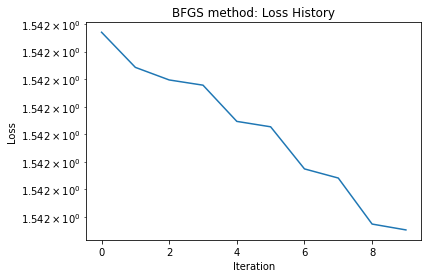

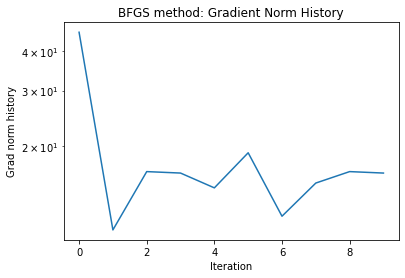

Integral of discretized step function: 1.0000 (Target for PDF: 1.0)


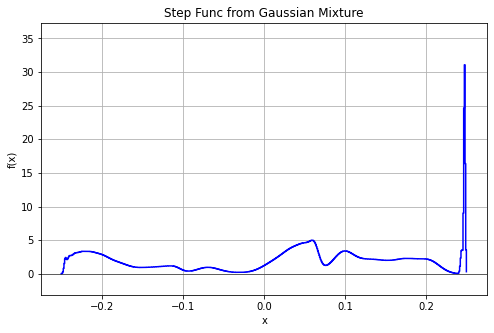

Max autoconv of this step function: 1.5451158439777886


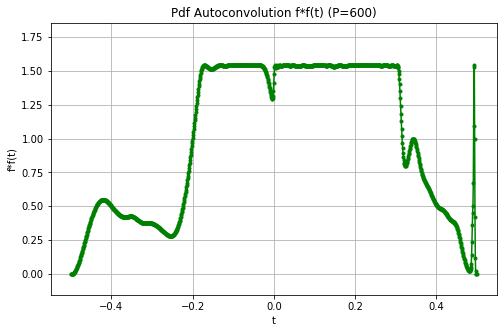

loss of the step function: tensor(1.5451, dtype=torch.float64)


In [13]:
from utils import *

P_val = 600

K_components = 50
N_grid_eval = 2*P_val # Number of points to evaluate autoconv for max
sigma_min_init = 0.0000001
sigma_max_init = 0.08 # (0.5 / 6.01) approx
lambda_sigma_upper_bound = 10
lambda_mu_bounds = 10

loss_fn_v3 = gaussian_mixture_max_autoconv_loss_v3_learnable_sigma(
    num_mixture_components=K_components,
    num_grid_points_autocorr=N_grid_eval,
    lambda_sigma_upper_bound=lambda_sigma_upper_bound,
    lambda_mu_bounds=lambda_mu_bounds,
    min_sigma_init_val=sigma_min_init,
    max_sigma_init_val=sigma_max_init
)

initial_log_weights = torch.randn(K_components, dtype=torch.float64)
initial_raw_means = torch.rand(K_components, dtype=torch.float64) * 0.4 - 0.2 # Start somewhat centered
# Initialize raw_log_sigmas so sigmas start in a reasonable range, e.g., around 0.03
initial_raw_log_sigmas = torch.log(torch.full((K_components,), 0.03, dtype=torch.float64))

combined_params = torch.cat([
    initial_log_weights, 
    initial_raw_means, 
    initial_raw_log_sigmas
]).requires_grad_(True)

# Alternative: load the 50 component solution from the previous cell.
combined_params = torch.load('gmm_50components_2000P_1000iter.pt')
combined_params = combined_params['best_h_params']
print(combined_params)
loss_val = loss_fn_v3(combined_params)
print(f"V3 Loss (learnable sigma): {loss_val.item()}")


h_params_bfgs_unconstrained = combined_params
h_params_bfgs_unconstrained.requires_grad = True

if 'history_bfgs_unconstrained_random' not in locals():
    history_bfgs_unconstrained_random = {}
else:
    h_params_bfgs_unconstrained.data = history_bfgs_unconstrained_random['best_h_params'].data.clone()

if K_components != 2*h_params_bfgs_unconstrained.shape[0]:
    history_bfgs_unconstrained_random = {}


max_iter = 10
bfgs_params = {}
bfgs_params['lr'] = 10
bfgs_params['history_size'] = 1000
bfgs_params['ls_params'] = {'c1': 0.0001, 'c2': 0.9}
# bfgs_params['line_search_fn'] = None # no line search function. Will likely blow up.
bfgs_params['line_search_fn'] = 'weak_wolfe' # good for later iterations
print_every = 10

history_bfgs_unconstrained_random = bfgs_method(h_params_bfgs_unconstrained, loss_fn_v3, max_iter, bfgs_params, print_every, history_bfgs_unconstrained_random)

print(h_params_bfgs_unconstrained)

print("Best loss found:", history_bfgs_unconstrained_random['min_loss_found'])


# semilogy plot of loss history
plt.semilogy(history_bfgs_unconstrained_random['loss_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("BFGS method: Loss History")
plt.show()

plt.semilogy(history_bfgs_unconstrained_random['grad_norm_history'])
plt.xlabel("Iteration")
plt.ylabel("Grad norm history")
plt.title("BFGS method: Gradient Norm History")
plt.show()


best_params = history_bfgs_unconstrained_random['best_h_params']

step_h = convert_gaussian_mixture_v3_to_step_function(
    combined_params=history_bfgs_unconstrained_random['best_h_params'],
    num_mixture_components=K_components,
    P_val_step_func=P_val,
    S_target_step_func=2*P_val,
    f_interval_min=-0.25,
    f_interval_max=0.25,
    min_sigma_init_val=sigma_min_init,
    max_sigma_init_val=sigma_max_init
)

f_x_min = -0.25
f_x_max = 0.25
delta_x_final_step = (f_x_max - f_x_min) / P_val
integral_of_final_step = torch.sum(step_h * delta_x_final_step).item()
print(f"Integral of discretized step function: {integral_of_final_step:.4f} (Target for PDF: 1.0)")

# You can then plot step_h or compute its autoconvolution using your existing utils
plot_rendered_step_function(step_h.detach().numpy(), (-0.25,0.25), "Step Func from Gaussian Mixture")
autoconv_step = compute_autoconvolution_values(step_h.detach(), delta_x_final_step, P_val)
conv_t_knots = np.linspace(2 * f_x_min, 2 * f_x_max, 2 * P_val + 1, dtype=float)

max_autoconv_step = torch.max(autoconv_step[1:-1]).item()
print(f"Max autoconv of this step function: {max_autoconv_step}")
plot_rendered_convolution(conv_t_knots, autoconv_step.detach().numpy(), title=f"Pdf Autoconvolution f*f(t) (P={P_val})")

loss_fn = constrained_loss(P_val)
print("loss of the step function:",loss_fn(step_h))

In [12]:
combined_params = torch.load('gmm_50components_2000P_1000iter.pt')
combined_params['best_h_params']

/var/folders/y5/4zrm18_56lzgk0gv8sz98s3w0000gn/T/ipykernel_76369/4233351598.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  combined_params = torch.load('gmm_50component

tensor([ 1.5278e+00, -4.3254e-01, -1.4187e+00, -2.4522e-01,  6.9312e-02,
        -8.1978e-01,  1.4369e+00,  4.7998e-01,  1.5907e+00,  1.9898e+00,
         5.1298e-01, -2.9821e-01,  8.6179e-01,  8.7756e-01,  6.4893e-01,
         3.5888e-02, -4.5244e-01,  4.1382e-01,  1.3399e+00, -8.8288e-02,
        -1.9593e+00,  2.6066e-01,  1.6441e-01,  8.5886e-01,  9.2832e-01,
        -1.1457e+00,  3.5508e-02, -1.8741e+00,  7.1074e-01,  5.4519e-01,
         1.1326e+00,  1.1935e+00,  1.3114e+00,  5.7978e-01, -1.6929e+00,
        -1.2647e-01,  6.0235e-01,  8.0189e-02, -3.1907e-01,  3.9525e-02,
        -1.0071e+00,  2.2066e+00, -1.4036e+00,  1.9843e+00, -8.2202e-01,
         1.0311e-01,  1.8176e+00,  1.0788e+00,  5.8275e-01,  3.5168e-01,
         1.7833e-01,  2.7661e-02,  2.1118e-03, -1.0927e-01,  2.2707e-02,
         2.4420e-02,  1.3132e-01,  7.2344e-03,  3.9901e-02,  2.4690e-01,
         4.2169e-02, -1.3828e-01,  2.8855e-02, -2.1746e-01,  3.6252e-02,
        -2.4104e-01, -2.4513e-01,  1.6414e-01,  5.3